# Clustering visualizer using predefined roles and features configuration

## Importing libraries

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import random

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

random.seed(123456789)

## Importing the datasets

In [108]:
data_path = "../data/"

clear_scaled_data_path = data_path + "clear_scaled_data.csv"
clear_data_path = data_path + "clear_data.csv"
data_with_nan_path = data_path + "data_with_nan.csv"
scaled_data_with_nan_path = data_path + "scaled_data_with_nan.csv"

clear_scaled_data = pd.read_csv(clear_scaled_data_path)
clear_data = pd.read_csv(clear_data_path)
data_with_nan = pd.read_csv(data_with_nan_path)
scaled_data_with_nan = pd.read_csv(scaled_data_with_nan_path)

## Define role and feature configuration

In [109]:
role_config = [
    {
        "name": "Engaged Participant",
        "conditions": {
            "VotePositive": [0.34, None],
            "VoteNegative": [0.32, None],
            "ReceivedNegative": [0.33, None],
            "ReceivedPositive": [0.37, None],
            "clicks_in_last_90_articles": [-0.25, 0.34]
        }
    },
    {
        "name": "Opinion Leader",
        "conditions": {
            "VotePositive": [0.34, None],
            "VoteNegative": [0.34, None],
            "ActivityCentrality": [0.46, None],
            "ReceivedPositive": [0.37, None],
            "GotFollowers": [0, 0.17],
            "TopicsDiversity": [None, -0.82]
        }
    },
    {
        "name": "Taciturns",
        "conditions": {
            "PostsAmount": [None, -0.09],
            "VotePositive": [None, -0.12],
            "VoteNegative": [None, -0.11],
            "clicks_in_last_90_articles": [None, -0.25],
            "ActivityCentrality": [None, -0.25]
        }
    },
    {
        "name": "Provokers",
        "conditions": {
            "PostsAmount": [0.27, None],
            "PostReplied": [0.34, None],
            "ReceivedPositive": [0.37, None],
            "ReceivedNegative": [0.33, None],
            "GotPostReplied": [0.36, None],
            "TopicsDiversity": [None, -0.82]
        }
    },
    {
        "name": "Flamers",
        "conditions": {
            "ReceivedNegative": [0.33, None],
            "GotPostReplied": [0.36, None],
            "ReceivedPositive": [-0.13, 0.37],
            "TopicsDiversity": [None, -0.82]
        }
    },
    {
        "name": "Connector",
        "conditions": {
            "ActivityCentrality": [0.46, None],
            "ReceivedPositive": [0.37, None],
            "VotePositive": [0.34, None],
            "VoteNegative": [0.32, None],
            "TopicsPostedIn": [0.37, None]
        }
    },
    {
        "name": "Discussion Leader",
        "conditions": {
            "PostsAmount": [0.27, None],
            "PostReplied": [0.34, None],
            "ReceivedPositive": [0.37, None],
            "ReceivedNegative": [0.33, None]
        }
    },
    {
        "name": "Silent Voter",
        "conditions": {
            "VotePositive": [0.34, None],
            "VoteNegative": [0.32, None],
            "PostsAmount": [None, -0.09],
            "ReceivedNegative": [None, 0.11],
            "ReceivedPositive": [None, 0.13]
        }
    }
]


In [110]:
def evaluate_conditions(row, conditions):
    for feature, (min_val, max_val) in conditions.items():
        if min_val is not None and row[feature] < min_val:
            return False
        if max_val is not None and row[feature] > max_val:
            return False
    return True

def assign_role(row, role_config):
    matching_roles = []
    for role in role_config:
        if evaluate_conditions(row, role["conditions"]):
            matching_roles.append(role["name"])
    if matching_roles:
        return random.choice(matching_roles)
    return "Uncategorized"

def assign_roles(data, role_config):
    data['Role'] = data.apply(assign_role, axis=1, args=(role_config,))
    return data

def perform_clustering(data, distance_threshold):
    linked = linkage(data.iloc[:, 1:-1], method='ward')  # remove userId and role cols
    cluster_labels = fcluster(linked, t=distance_threshold, criterion='distance')
    data['Cluster'] = cluster_labels
    return data

def assign_roles_only(data, role_config):
    data = assign_roles(data, role_config)
    return data

def cluster_only(data, distance_threshold=5):
    data = perform_clustering(data, distance_threshold)
    return data

## Assign roles/features and do the clustering 

In [111]:
data = assign_roles_only(clear_scaled_data, role_config)
data = cluster_only(data, 35)

## Information after the process

Total number of users: 11968

Total number of roles: 9

Number of users per role:
    Uncategorized: 7996
    Taciturns: 585
    Discussion Leader: 1258
    Connector: 545
    Opinion Leader: 169
    Provokers: 808
    Engaged Participant: 156
    Silent Voter: 310
    Flamers: 141


Total number of clusters: 9

Number of users per cluster:
    Cluster 4: 1545
    Cluster 5: 3972
    Cluster 7: 915
    Cluster 8: 649
    Cluster 2: 744
    Cluster 6: 990
    Cluster 3: 761
    Cluster 9: 1546
    Cluster 1: 846


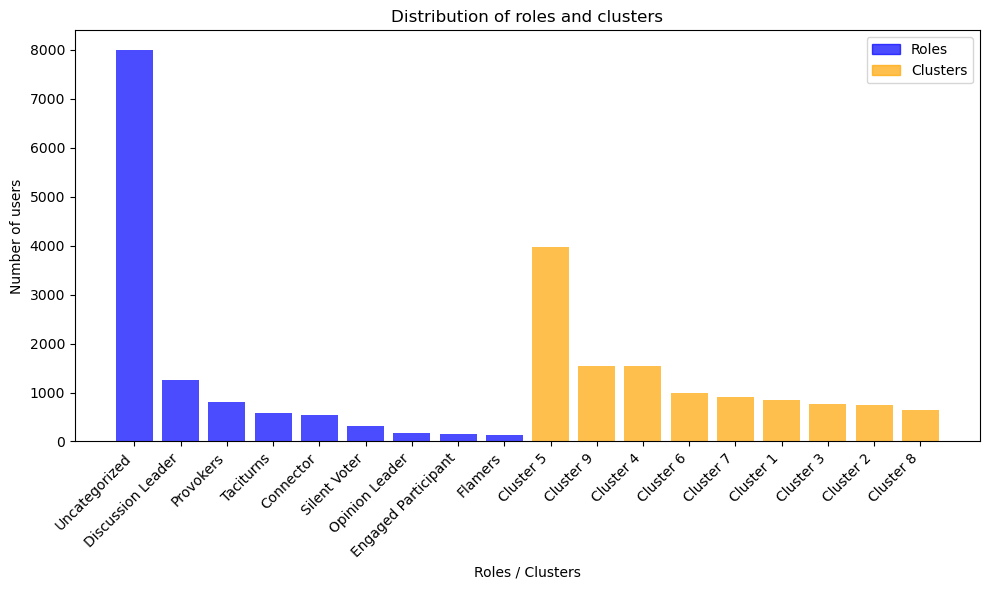

In [112]:
def get_role_count(data):
    role_counts = Counter()
    for _ , row in data.iterrows():
        roles = row['Role'].split(" / ") if " / " in row['Role'] else [row['Role']]
        for role in roles:
            role_counts[role] += 1
        if len(roles) > 1:
            combined_role = " / ".join(sorted(roles))
            role_counts[combined_role] += 1
    return role_counts

def get_cluster_count(data):
    cluster_counts = Counter()
    for _, row in data.iterrows():
        cluster = row["Cluster"]
        cluster_counts[cluster] += 1
    return cluster_counts


category_counts = get_role_count(data)
cluster_counts = get_cluster_count(data)

print(f"Total number of users: {len(data)}\n")
print(f"Total number of roles: {len(category_counts)}\n")
print("Number of users per role:")
for role, count in category_counts.items():
    print(f"    {role}: {count}")

print("\n=========================\n")

print(f"Total number of clusters: {len(cluster_counts)}\n")
print("Number of users per cluster:")
for cluster, count in cluster_counts.items():
    print(f"    Cluster {cluster}: {count}")


# Plot histograms to show distribution of roles and clusters
plt.figure(figsize=(10, 6))
sorted_roles = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
role_names = [role[0] for role in sorted_roles]
role_values = [role[1] for role in sorted_roles]

sorted_clusters = sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True)
cluster_names = [f"Cluster {cluster[0]}" for cluster in sorted_clusters]
cluster_values = [cluster[1] for cluster in sorted_clusters]

combined_names = role_names + cluster_names
combined_values = role_values + cluster_values
combined_colors = ['blue'] * len(role_names) + ['orange'] * len(cluster_names)

plt.bar(combined_names, combined_values, color=combined_colors, alpha=0.7)

plt.title("Distribution of roles and clusters")
plt.xlabel("Roles / Clusters")
plt.ylabel("Number of users")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend(handles=[
    plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.7, label='Roles'),
    plt.Rectangle((0, 0), 1, 1, color='orange', alpha=0.7, label='Clusters')
])
plt.show()

## Compare the results of the clustering with the predefined roles

In [113]:
def compare_clustering_vs_roles(data):
    role_labels = data['Role']
    cluster_labels = data['Cluster']

    ari_score = adjusted_rand_score(role_labels, cluster_labels)
    nmi_score = normalized_mutual_info_score(role_labels, cluster_labels)

    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

compare_clustering_vs_roles(data)

Adjusted Rand Index (ARI): 0.2197
Normalized Mutual Information (NMI): 0.3212


In [114]:
def get_role_cluster_overlap(data):
    overlap_counts = data.copy().groupby(['Role', 'Cluster']).size().reset_index(name='Count')
    return overlap_counts

overlap_counts = get_role_cluster_overlap(data)

dominant_clusters = overlap_counts.loc[overlap_counts.groupby('Role')['Count'].idxmax()].sort_values(by="Count", ascending=False).reset_index(drop=True)
print(dominant_clusters.to_string(index=False))

total_overlap_users = overlap_counts["Count"].sum()
total_users = len(data)
overlap_percentage = (total_overlap_users / total_users) * 100

               Role  Cluster  Count
      Uncategorized        5   3767
          Taciturns        4    412
  Discussion Leader        2    398
          Provokers        2    268
       Silent Voter        6    248
          Connector        3    210
     Opinion Leader        1     79
            Flamers        7     61
Engaged Participant        1     59


## Plotting the roles in 2D

In [115]:
def visualize_roles_2D(data):
    data = data.copy()
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data.iloc[:, 1:-2])  # Exclude userId, role and cluster cols
    data['PCA1'] = reduced_data[:, 0]
    data['PCA2'] = reduced_data[:, 1]

    plt.figure(figsize=(10, 7))
    for role in data['Role'].unique():
        role_data = data[data['Role'] == role]
        plt.scatter(role_data['PCA1'], role_data['PCA2'], label=f'Role {role}', alpha=0.7)
    plt.title('Roles in 2D PCA space ')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

## Plotting the roles in 3D

In [116]:
def visualize_roles_3D(data):
    data = data.copy()
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    pca_3d = PCA(n_components=3)
    reduced_data_3d = pca_3d.fit_transform(data[numeric_columns])  # only numeric cols

    data['PCA1'] = reduced_data_3d[:, 0]
    data['PCA2'] = reduced_data_3d[:, 1]
    data['PCA3'] = reduced_data_3d[:, 2]

    fig = plt.figure(figsize=(18, 12))
    ax = fig.add_subplot(111, projection='3d')
    for role in data['Role'].unique():
        role_data = data[data['Role'] == role]
        ax.scatter(role_data['PCA1'], role_data['PCA2'], role_data['PCA3'], label=f'Role {role}', alpha=0.7)
    ax.set_title('Roles in 3D PCA space')
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.legend()
    ax.set_box_aspect([1, 1, 1])
    plt.show()


## Plotting the clusters in 2D

In [117]:
def visualize_clusters_2D(data):
    data = data.copy()
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data.iloc[:, 1:-2])  # remove userId, role  and cluster
    data["PCA1"], data["PCA2"] = reduced_data[:, 0], reduced_data[:, 1]

    plt.figure(figsize=(10, 7))
    for cluster in data["Cluster"].unique():
        cluster_data = data[data["Cluster"] == cluster]
        plt.scatter(
            cluster_data["PCA1"],
            cluster_data["PCA2"],
            label=f"Cluster {cluster}" if cluster <= 20 else None,
            alpha=0.7,
        )
    plt.title("Clusters in 2D PCA space")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.show()


## Plottin the clusters in 3D

In [118]:
def visualize_clusters_3D(data):
    data = data.copy()
    numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
    pca_3d = PCA(n_components=3)
    reduced_data_3d = pca_3d.fit_transform(data[numeric_columns])  # Only numeric cols

    data["PCA1"], data["PCA2"], data["PCA3"] = (
        reduced_data_3d[:, 0],
        reduced_data_3d[:, 1],
        reduced_data_3d[:, 2],
    )

    fig = plt.figure(figsize=(18, 12))
    ax = fig.add_subplot(111, projection="3d")
    for cluster in data["Cluster"].unique():
        cluster_data = data[data["Cluster"] == cluster]
        ax.scatter(
            cluster_data["PCA1"],
            cluster_data["PCA2"],
            cluster_data["PCA3"],
            label=f"Cluster {cluster}" if cluster <= 20 else None,
            alpha=0.7,
        )
    ax.set_title("Clusters in 3D PCA space")
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")
    ax.legend()
    ax.set_box_aspect([1, 1, 1])
    plt.show()


## Visualize the results

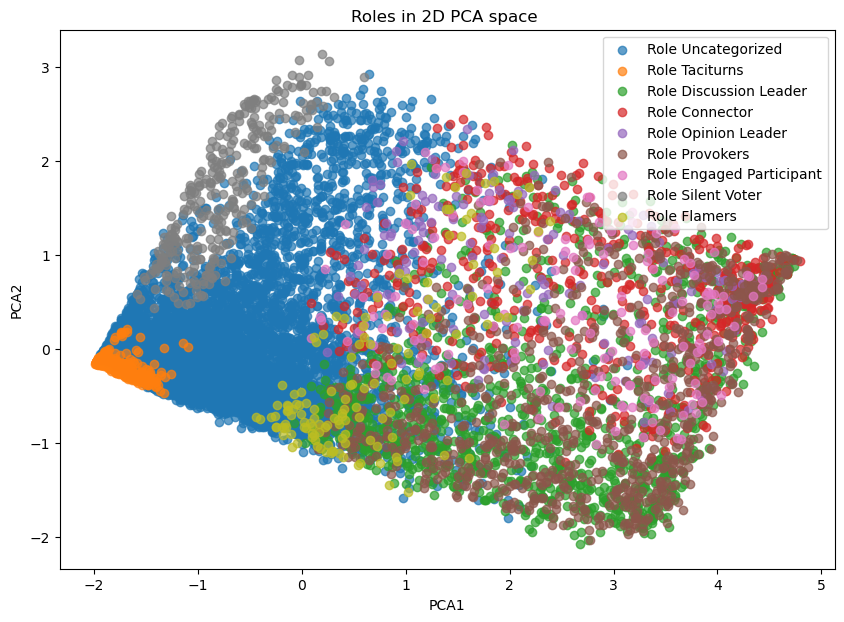

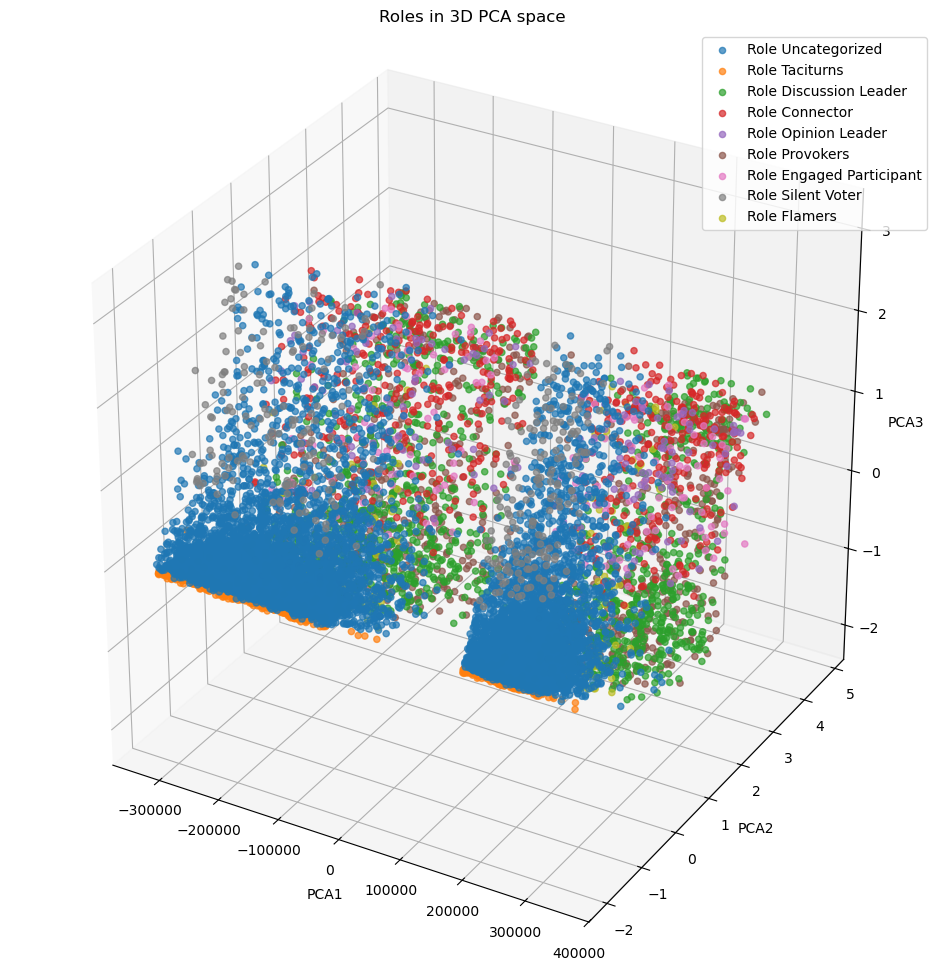

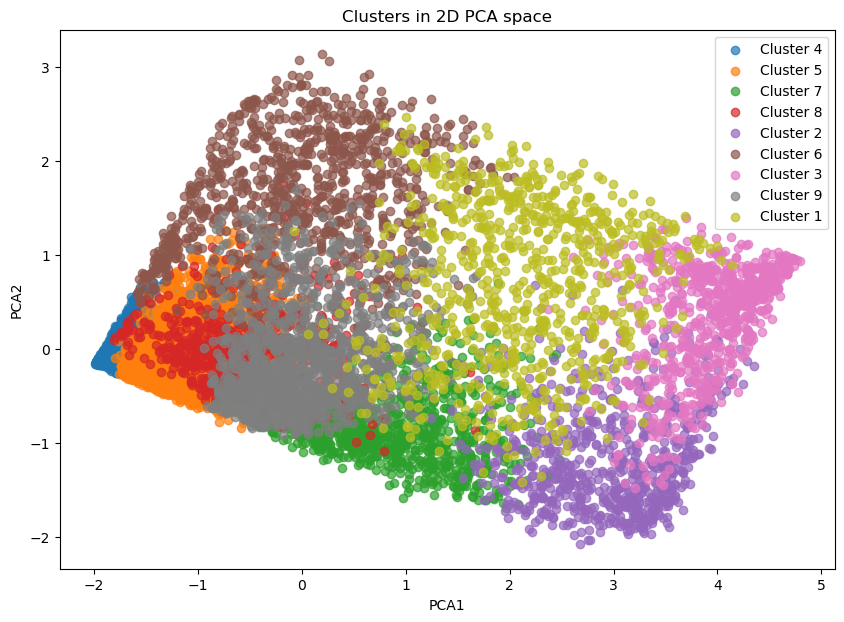

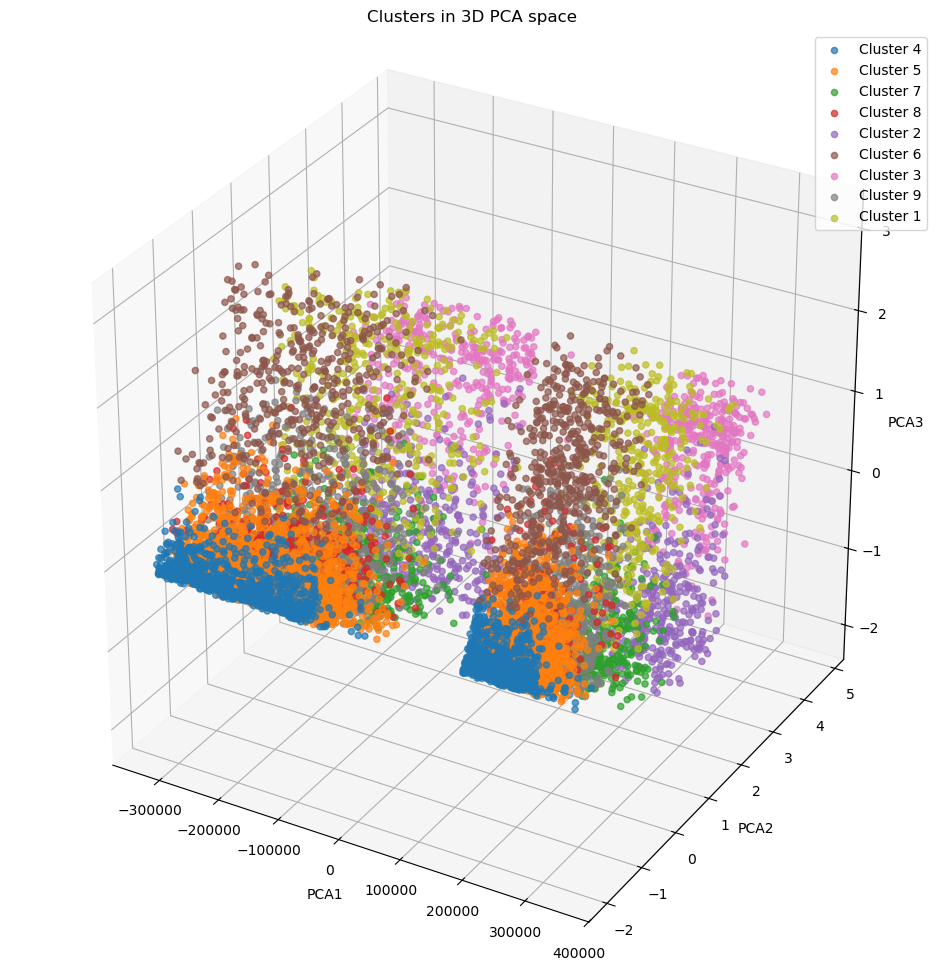

In [119]:
visualize_roles_2D(data)
visualize_roles_3D(data)
visualize_clusters_2D(data)
visualize_clusters_3D(data)